In [38]:
from cmath import sqrt
import numpy as np
from autograd import grad
import autograd.numpy as np1
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
from scipy.optimize import BFGS,SR1
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint,LinearConstraint
import time

In [39]:

# Set parameters
n = 100
a = np.random.rand(1, n)
beta = 0.741271
e = np.array([i+1 for i in range(n)])
A = np.random.rand(n, n)
b = np.random.rand(n, 1)
alpha = 10 * np.random.rand(1, 1)  # Fix syntax: add * between 10 and np.random.rand

# Calculate L
while 2 * alpha <= 3 * (beta ** (3/2)) * np.sqrt(n):
    alpha = 10 * np.random.rand(1, 1)
    L = 4 * (beta ** (3/2)) * np.sqrt(n) + 3 * alpha  # Calculate L inside the loop to update with new alpha

# Print values for tracking
print(f"n = {n}")
print(f"a = {a}")
print(f"beta = {beta}")
print(f"e = {e}")
print(f"A = {A}")
print(f"b = {b}")
print(f"alpha = {alpha[0][0]}")  # Access the scalar value from the 2D array
print(f"L = {L[0][0]}")  # Access the scalar value from the 2D array


n = 100
a = [[0.59819135 0.77399297 0.4966392  0.06378772 0.80496965 0.97609272
  0.44076675 0.88436671 0.41352619 0.01373745 0.10731773 0.34642962
  0.90979183 0.59552293 0.28815238 0.85263645 0.45955259 0.96153187
  0.41494668 0.13789971 0.70219935 0.85567556 0.93027155 0.40031528
  0.54202247 0.86180985 0.12490425 0.0568093  0.08305499 0.86204207
  0.24875137 0.27909682 0.74180961 0.97264651 0.17556362 0.71746338
  0.75391146 0.56671559 0.18998942 0.14720438 0.89842353 0.37856326
  0.05348916 0.54901333 0.85091178 0.79174712 0.45387856 0.40189816
  0.4065241  0.73642782 0.86525852 0.59227999 0.76627536 0.5650112
  0.65111945 0.14359037 0.06305322 0.20645674 0.41858632 0.61411108
  0.33236406 0.41990154 0.22334661 0.50638819 0.30177626 0.72225877
  0.39728015 0.69707263 0.83463535 0.34418588 0.04183535 0.94687399
  0.29954728 0.57968048 0.6975844  0.49704471 0.79944172 0.66949756
  0.99497205 0.97370318 0.78711895 0.11754786 0.93444839 0.32163577
  0.79361305 0.20047632 0.98239169 0.

In [40]:
def f(x):
    return np1.dot(a,x.T) + alpha*np1.dot(x,x.T) + (beta/np1.sqrt(1+beta*np1.dot(x,x.T)))*np1.dot(e,x.T)
def g1(x):
    return 1- np1.prod(x)
g1_dx = grad(g1)
f_dx = grad(f)
B = A.tolist()
C = b.reshape(1,n).tolist()[0]
nonlinear_constraint = NonlinearConstraint(g1, -np.inf, 0, jac=g1_dx, hess=BFGS())
# linear_constraint = LinearConstraint(B, C,[np.inf for i in range(n)])
# linear_constraint = LinearConstraint([[1 for i in range(n)]], 1,np.inf)
bounds = Bounds([0.0001 for i in range(n)], [np.inf for i in range(n)])


GDA

Converged at iteration: 7
[1.12220976 1.1140332  1.12005094 1.13102013 1.10512922 1.09722603
 1.11115206 1.0948138  1.10670727 1.11650981 1.11093117 1.10088518
 1.08107534 1.08803323 1.09482496 1.07509513 1.08440023 1.06673321
 1.08059474 1.08641374 1.06685067 1.05975856 1.05503704 1.06823873
 1.06148413 1.04954261 1.06883801 1.0683285  1.06500715 1.03960675
 1.05505184 1.05165469 1.03569368 1.02660964 1.0472026  1.02904302
 1.0255616  1.02848292 1.03688109 1.03565599 1.0118038  1.02412488
 1.03099678 1.01445446 1.00359372 1.00286905 1.00994079 1.00901087
 1.00649546 0.99495554 0.98906604 0.99423533 0.98711276 0.99029776
 0.98560595 0.99722645 0.99709887 0.99079383 0.98265984 0.97505166
 0.9803751  0.97569856 0.9787136  0.96879291 0.97199903 0.95851378
 0.96488343 0.95468498 0.94884241 0.95950778 0.96528136 0.93929005
 0.95394495 0.94439239 0.93913274 0.94211823 0.93213749 0.93328488
 0.92283253 0.92121991 0.92378361 0.93872309 0.91578618 0.92912109
 0.91504961 0.92787033 0.90611843 0.

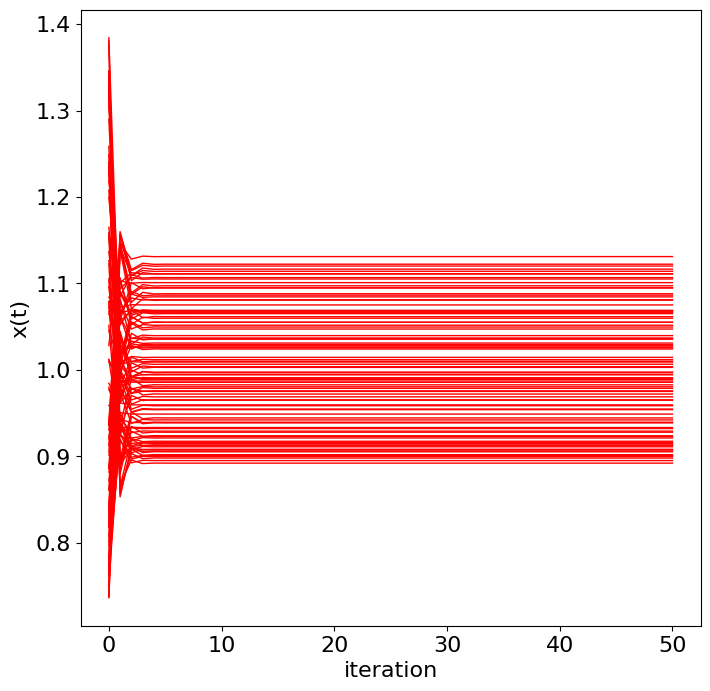

In [ ]:
def rosen(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def find_min(y, n):
    x = np.random.rand(1, n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point", hess=BFGS(),
                   constraints=[nonlinear_constraint], method='trust-constr', 
                   options={'disp': False}, bounds=bounds)
    return res.x

def gda(x, max_iters, f, f_dx, n):
    res = []
    val = []
    lda = 5 / L
    sigma = 0.1  # 100
    K = np.random.rand(1, 1)
    res.append(x)
    val.append(f(x))
    x_pre = x
    for t in range(max_iters):
        y = x - lda * f_dx(x)
        x_pre = x.copy()
        x = find_min(y, n)
        if f(x) - f(x_pre) + sigma * (np.dot(f_dx(x_pre).T, x_pre - x)) <= 0:
            lda = lda
        else:
            lda = K * lda
        res.append(x)
        val.append(f(x))
        if np.allclose(x, x_pre, rtol=1e-5, atol=1e-8):
            print(f"Converged at iteration: {len(res) - 1}")  # In số lần lặp thực tế
            break
    print(x)
    print(f(x))
    # Đảm bảo res có đủ max_iters + 1 phần tử bằng cách thêm giá trị cuối
    while len(res) < max_iters + 1:
        res.append(res[-1])
        val.append(val[-1])
    return res, val, x, f(x)

def plot_x(sol_all, count, max_iters):
    t = [i for i in range(max_iters + 1)]
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 16})
    colors = ['r', 'g', 'y', 'b', 'brown']
    for i in range(count):
        for j in range(n):
            plt.plot(t, sol_all[i][:, j], color=colors[i], linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.show()

# Main execution
num = 1  # number of init points
max_iters = 50  # number of iterations
max_iters1 = 50
sol_all, sol_all1 = [], []
val_all, val_all1 = [], []
count = 0
epsilon = 0.1

for i in range(num):
    x0 = np.random.rand(1, n)
    x0 = find_min(x0, n)  # init point
    g1x = g1(x0)
    count += 1
    res, val, x, _ = gda(x0, max_iters, f, f_dx, n)
    tmp = np.array(res)[:, :]
    sol_all.append(tmp)
    val_all.append(val)
plot_x(sol_all, count, max_iters)

GD

Converged at iteration: 17
[1.12220023 1.11403573 1.12003703 1.13100592 1.10512917 1.09722859
 1.11115396 1.09480763 1.10670859 1.11650332 1.11092543 1.10089265
 1.08107425 1.08802721 1.0948254  1.0750991  1.08439144 1.06674253
 1.08058803 1.08640786 1.06684301 1.05975326 1.05504214 1.06824703
 1.06148444 1.04953726 1.06883344 1.06832497 1.0650021  1.0396007
 1.0550527  1.05166323 1.03569669 1.02660828 1.04720089 1.02903948
 1.02556528 1.02848413 1.03687812 1.03565409 1.01181045 1.02413005
 1.03100073 1.01445805 1.00359319 1.0028655  1.00993743 1.00900981
 1.00649995 0.99496012 0.98907102 0.99423213 0.98711372 0.99029885
 0.98560271 0.99722924 0.99709882 0.99079778 0.98265897 0.97504957
 0.98037716 0.97570351 0.97871573 0.96879261 0.97199746 0.95851819
 0.96488203 0.95468569 0.94884663 0.95951171 0.96528422 0.93929004
 0.95394806 0.94439365 0.93913289 0.94211848 0.93213868 0.93328725
 0.92283434 0.92121965 0.92378497 0.93872167 0.91578586 0.92912268
 0.91504926 0.92787114 0.90611797 0.

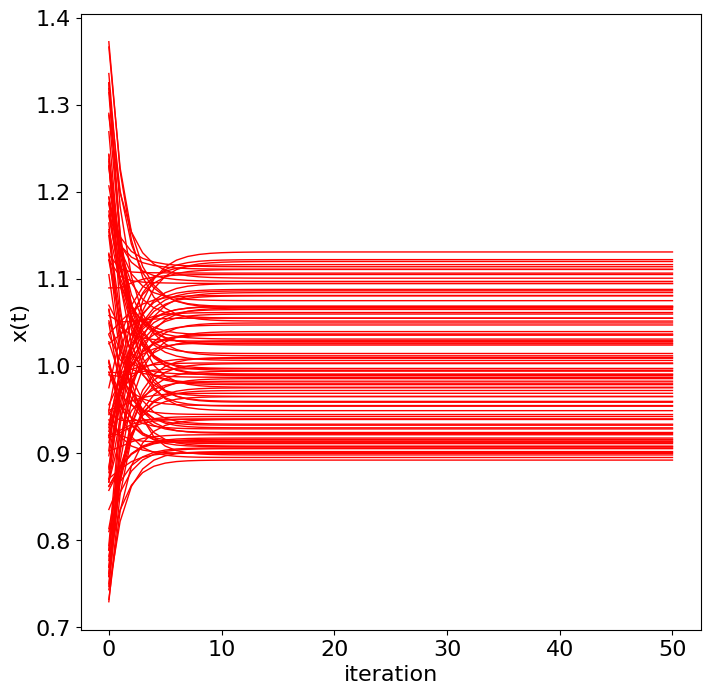

In [42]:
def rosen(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def find_min(y, n):
    x = np.random.rand(1, n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point", hess=BFGS(),
                   constraints=[nonlinear_constraint], method='trust-constr', 
                   options={'disp': False}, bounds=bounds)
    return res.x

def gd(x, max_iters, f, f_dx, n):
    res = []
    val = []
    lda = 1 / L  # Fixed step size
    res.append(x)
    val.append(f(x))
    x_pre = x
    for t in range(max_iters):
        y = x - lda * f_dx(x)
        x_pre = x.copy()
        x = find_min(y, n)
        res.append(x)
        val.append(f(x))
        if np.allclose(x, x_pre, rtol=1e-5, atol=1e-8):
            print(f"Converged at iteration: {len(res) - 1}")  # In số lần lặp thực tế
            break
    print(x)
    print(f(x))
    # Đảm bảo res có đủ max_iters + 1 phần tử bằng cách thêm giá trị cuối
    while len(res)< max_iters + 1:
        res.append(res[-1])
        val.append(val[-1])
    return res, val, x, f(x)

def plot_x(sol_all, count, max_iters):
    t = range(max_iters + 1)  # Giữ trục x từ 0 đến max_iters
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 16})
    colors = ['r', 'g', 'y', 'b', 'brown']
    for i in range(count):
        for j in range(n):
            plt.plot(t, sol_all[i][:, j], color=colors[i], linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.show()

# Main execution
num = 1  # number of init points
max_iters = 50  # number of iterations
max_iters1 = 50
sol_all, sol_all1 = [], []
val_all, val_all1 = [], []
count = 0
epsilon = 0.1

for i in range(num):
    x0 = np.random.rand(1, n)
    x0 = find_min(x0, n)  # init point
    g1x = g1(x0)
    count += 1
    res, val, x, _ = gd(x0, max_iters, f, f_dx, n)
    tmp = np.array(res)[:, :]
    sol_all.append(tmp)
    val_all.append(val)
plot_x(sol_all, count, max_iters)